# SQL analysis with differential privacy guarantees

The purpose of this notebook is to illustrate the process of *transforming a standard SQL query into a differentially private SQL query*.

Our goal here is to demonstrate how this complex transformation of an SQL query into a differentially private version can be achieved with ease using Qrlew.

The main idea of Qrlew is to parse and rewrite SQL queries into *Relations*: an [Intermediate Representation](https://en.wikipedia.org/wiki/Intermediate_representation) (IR) that is well-suited for various rewriting tasks.

*Relations* may be of different kinds:
- `Map`s typically represent the transform of an input *Relation* row by row, therefore, naturaly preserving the *privacy unit*,
- `Reduce`s represent aggregations that can be turned into DP equivalent
- `Join`s combine two input *Relations*
- `Table`s are simply sources.

This representation simplifies the process of rewriting queries and reduces dependencies on the diverse range of syntactic constructs present in SQL.

## Install the database and packages


In [ ]:
%%capture
# Load the database
# Inspired by https://colab.research.google.com/github/tensorflow/io/blob/master/docs/tutorials/postgresql.ipynb#scrollTo=YUj0878jPyz7
!sudo apt-get -y -qq update
!sudo apt-get -y -qq install postgresql-14
# Start postgresql server
!sudo sed -i "s/port = 5432/port = 5433/g" /etc/postgresql/14/main/postgresql.conf
!sudo service postgresql start
# Set password
!sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'pyqrlew-db'"
!pip install -U pyqrlew matplotlib graphviz dp_accounting

In [1]:
from pyqrlew.io import PostgreSQL
# Read data
database = PostgreSQL()
dataset = database.retail()

Error response from daemon: network with name qrlew-net already exists


For our analysis, we will use the Qrlew built-in sample datasets `retail` and an Postgres connection.

Note that you can also load one or several csv files or use another SQL engine.

## The `Relation`: an intermediate represention for SQL rewritting

The `retail` dataset contains 3 tables, each can be converted into a `Relation::Table`:

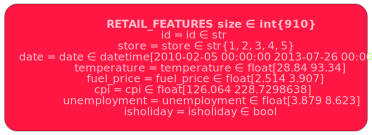

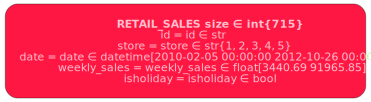

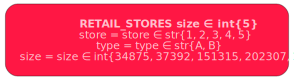

In [2]:
import graphviz
display(graphviz.Source(dataset.relations()[0][1].dot()))
display(graphviz.Source(dataset.relations()[1][1].dot()))
display(graphviz.Source(dataset.relations()[2][1].dot()))

Each `Relation::Table` contains the size of the table (which can be approximate with DP) and the columns in the tables with their name and type.

Before using any differential privacy mechanism, it is essential to determine:
- the *privacy unit*, i.e. the *user* identifier,
- the *sensitivity of the aggregation functions*, i.e. the maximal contribution a user may have on the result,
- the values of the `GROUP BY` columns that can be safely released

## The privacy unit

In this example, let's consider that we want to protect the `id` column of the tables `features` and `sales`.

The tables `store` is linked to `features` via foreign keys.

Then each table have a privacy unit (even if it is not directly in the table):
- `features`: column `id`
- `stores`: the privacy unit is the column `id` of the `feature` table. It is obtained by joining the tables `features` and `stores` with the condition `features.store = stores.store`
- `sales`: column `id`

We code the privacy unit as:

In [3]:
privacy_unit = [
    ("features", [], "id"),
    ("stores", [("store", "features", "store")], "id"),
    ("sales", [], "id")
]
# Other arguments that will be explained later
budget = {"epsilon": 1.0, "delta": 5e-4}
synthetic_data = [
    (["retail", "features"], ["retail", "features_sd"]),
]

The `privacy_unit` is a vector whose each element is a tuple with the convention: `(table_name, join_path, id_column)` with:
- `table_name` the name of the table,
- `join_path` a vector storing the joins whose each item `(column_name, table_name, column)` represents a foreign key,
- `id_column` the name of the column which is the privacy unit.

The `Relation` method `protect` allows to propagate the **privacy unit** through all the relations:

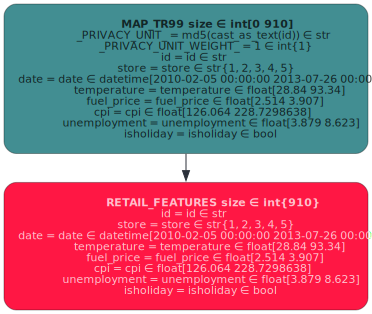

In [4]:
pup_features = dataset.relations()[0][1].rewrite_as_privacy_unit_preserving(
    dataset,
    privacy_unit,
    budget,
    synthetic_data,
)
display(graphviz.Source(pup_features.relation().dot()))

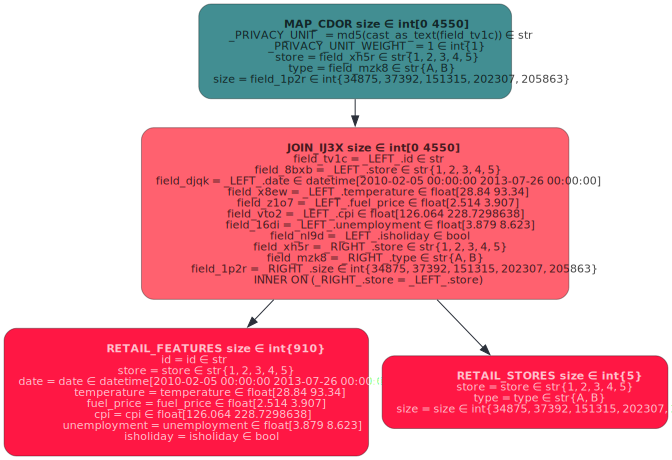

In [5]:
pup_stores = dataset.relations()[2][1].rewrite_as_privacy_unit_preserving(
    dataset,
    privacy_unit,
    budget,
    synthetic_data
)
display(graphviz.Source(pup_stores.relation().dot()))

We notice that to protect the `features` table we just have to hash the values of the `id` column and store them into the `_PRIVACY_UNIT_` while to protect the `store` table we had to make a join before.

## The sensitivity

In the case we want to relase the result of query : `SELECT SUM(3 * fuel_price + temperature / 10) FROM retail.features`, we have to compute the sensitivity of the `SUM(3 * fuel_price + temperature / 10)` aggregation.

The user provides the ranges of the inputs column in the `WHERE` clause of the query, then these values are propagated through all the relations.

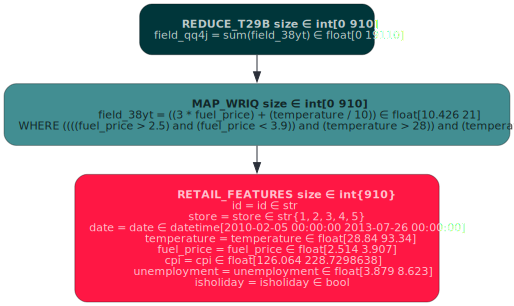

In [5]:
relation = dataset.sql('SELECT SUM(3 * fuel_price + temperature / 10) FROM retail.features WHERE fuel_price > 2.5 AND fuel_price < 3.9 AND temperature > 28 AND temperature < 93')
display(graphviz.Source(relation.dot()))

More information about the ranges propagation can be found [here](https://github.com/Qrlew/pyqrlew/blob/main/examples/range_propagation.ipynb).

## The protection of the GROUP BY keys

As explained in [Wilson et al. (2019)](https://arxiv.org/abs/1909.01917) and [this post](https://www.sarus.tech/post/the-protection-of-grouping-keys-in-the-context-of-differentially-private-sql), releasing the values of the grouping columns may leak some sensitive information.

To avoid that, two methods can be used:
- if the grouping keys have public values, we can release the propagated public values,
- otherwise we can use the tau-thresholding mechanism.

In the following cell, we show how the public values are propagated and then can be used in the DP rewriting.

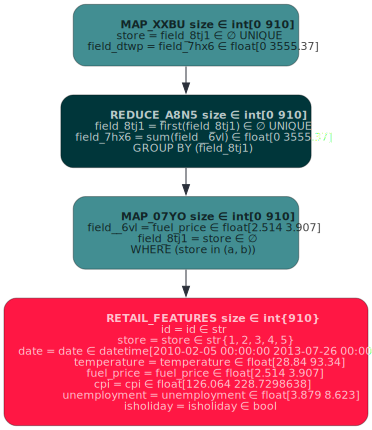

In [6]:
relation = dataset.sql("SELECT store, SUM(fuel_price) FROM retail.features WHERE store IN ('a', 'b') GROUP BY store ")
display(graphviz.Source(relation.dot()))

## Rewritting with DP

The rewritting with DP is done in 3 steps:
- **Protect** the input `Relation` as described before
- **DP-rewritting of the grouping keys**: a grouping key can be released if already public or if it appears in enough users rows,
- **Add noise** scaled by the privacy parameters to each aggregation.


We use the `rewrite_with_differential_privacy` method that transforms a `Relation` into its differentially private equivalent.

It inputs:
- `dataset`: the `Dataset` we want to query, 
- `privacy_unit`: the privacy unit described previously, 
- `privacy parameters`: the $(\varepsilon, \delta)$ privacy parameters,
- `synthetic_data`: an **optional** list giving the correpondance between the original tables and their synthetic version. Each table must be specified. The list is made of two-element tuples whose first element is a list representing the path to the original table (e.g.: `["retail", "features"]` for "retail.features" table or `["features"]` for the "feature" table) and the second element, the path to the synthetic table. 

In [7]:
privacy_unit = [
    ("stores", [("store", "features", "store")], "id"),
    ("features", [], "id"),
    ("sales", [], "id")
]
budget = {"epsilon": 1.0, "delta": 5e-4}
synthetic_data = None

query = "SELECT SUM(fuel_price) AS my_sum FROM retail.features WHERE fuel_price > 2.514 AND fuel_price < 3.907"
relation = dataset.sql(query)

relation_with_dp_event = relation.rewrite_with_differential_privacy(
    dataset,
    privacy_unit,
    budget,
    synthetic_data,
)
dp_relation = relation_with_dp_event.relation()
mechanisms_used = relation_with_dp_event.dp_event()

In [8]:
print(relation_with_dp_event)

Relation: SELECT my_sum AS my_sum FROM ( SELECT _SUM_field__6vl AS my_sum FROM ( SELECT least(3555.37, greatest(0, (coalesce(_SUM_field__6vl, 0) + (15.455181404019267 * (sqrt((-2 * ln(random()))) * cos((6.283185307179586 * random()))))))) AS _SUM_field__6vl FROM ( SELECT sum(field_q9u_) AS _SUM_field__6vl FROM ( SELECT _CLIPPED_field__6vl AS field_q9u_ FROM ( SELECT _PRIVACY_UNIT_ AS _PRIVACY_UNIT_, _PRIVACY_UNIT_WEIGHT_ AS _PRIVACY_UNIT_WEIGHT_, field__6vl AS field__6vl, _SCALE_FACTOR__PRIVACY_UNIT_ AS _SCALE_FACTOR__PRIVACY_UNIT_, _SCALE_FACTOR_field__6vl AS _SCALE_FACTOR_field__6vl, (field__6vl * _SCALE_FACTOR_field__6vl) AS _CLIPPED_field__6vl FROM ( SELECT map_8359._PRIVACY_UNIT_ AS _PRIVACY_UNIT_, map_8359._PRIVACY_UNIT_WEIGHT_ AS _PRIVACY_UNIT_WEIGHT_, map_8359.field__6vl AS field__6vl, map_27uj._PRIVACY_UNIT_ AS _SCALE_FACTOR__PRIVACY_UNIT_, map_27uj.field__6vl AS _SCALE_FACTOR_field__6vl FROM ( SELECT coalesce(cast_as_text(_PRIVACY_UNIT_), _PRIVACY_UNIT_DEFAULT_) AS _PRIVACY_U

The ouput is a tuple made of two elements:
- The first element is the `Relation` rewritten with dp,
- the second element is a `PrivateQuery` which stores the DP mechanims invoked during the rewritting.


In the present case, we have used only a gaussian mechanim since our query contain only a simple aggregate and no `GROUP BY`.

In [9]:
from dp_accounting import DpEvent
print(mechanisms_used.to_named_tuple())
print(DpEvent.from_named_tuple(mechanisms_used.to_named_tuple()))

{'module_name': 'dp_accounting.dp_event', 'class_name': 'GaussianDpEvent', 'noise_multiplier': 15.455181404019267, '_fields': ['module_name', 'class_name', 'noise_multiplier']}


AttributeError: 'dict' object has no attribute '_fields'

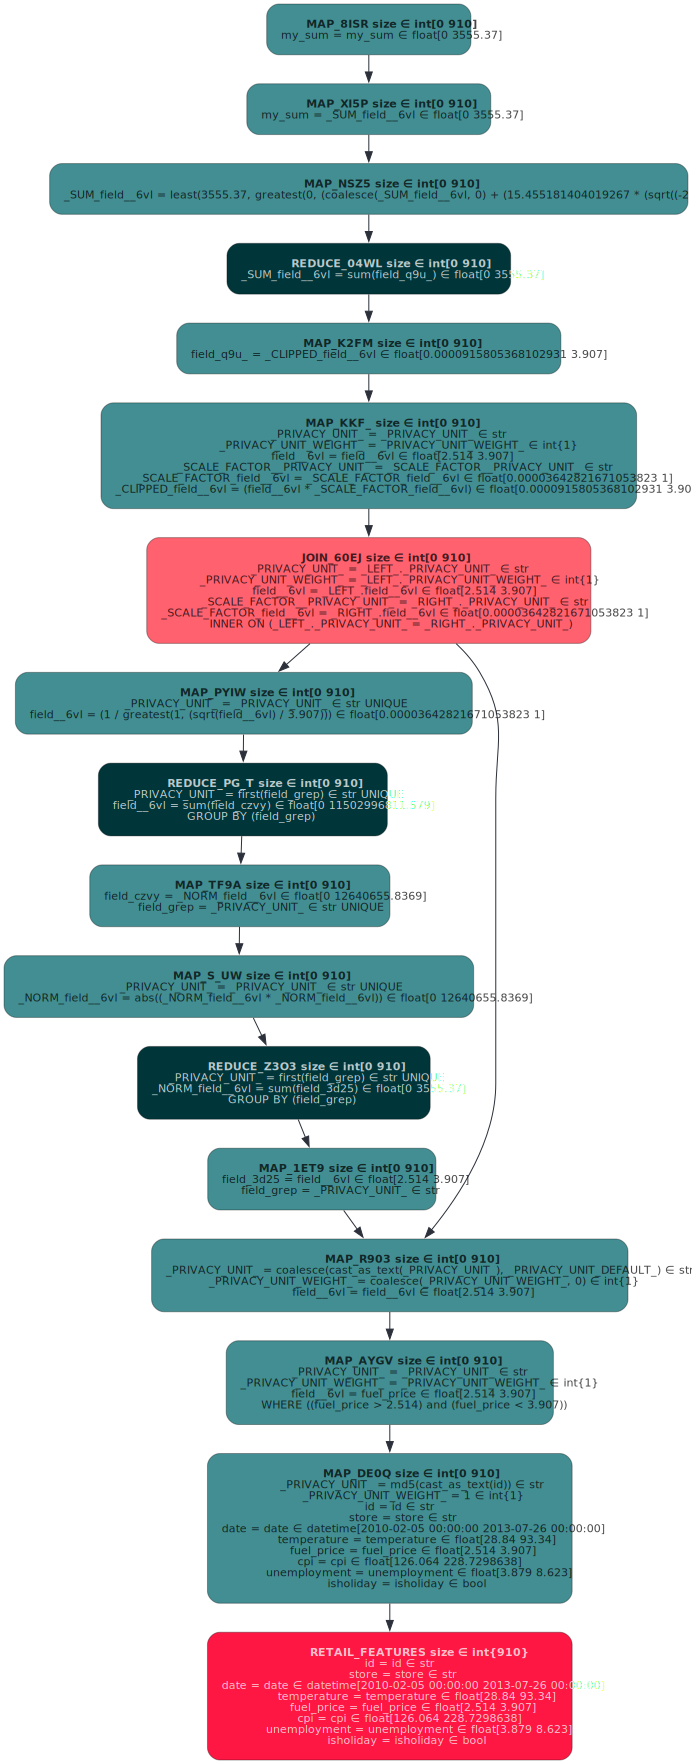

In [13]:
display(graphviz.Source(dp_relation.dot()))

The `Relation` can be translated into an SQL query:

In [14]:
MAGENTA_COLOR = '\033[35m'
BLUE_COLOR = '\033[34m'
RESET_COLOR = '\033[0m'

def print_query(query: str):
    keywords = ["SELECT", "AS", "GROUP BY", "LIMIT", "ORDER BY", "WHERE"]
    colored_query = query
    colored_query = colored_query.replace("WITH", "WITH\n ")
    colored_query = colored_query.replace(" SELECT", "\nSELECT")
    colored_query = colored_query.replace("),", "),\n ")
    for word in keywords:
        colored_query = colored_query.replace(word, MAGENTA_COLOR + word + RESET_COLOR)
    colored_query = colored_query.replace("WITH", BLUE_COLOR + "WITH" + RESET_COLOR)
    print(colored_query)


dp_query = dp_relation.render()
print_query(dp_query)

WITH
  map_de0q (_PRIVACY_UNIT_, _PRIVACY_UNIT_WEIGHT_, id, store, date, temperature, fuel_price, cpi, unemployment, isholiday) AS (SELECT MD5(CAST(id AS TEXT)) AS _PRIVACY_UNIT_, 1 AS _PRIVACY_UNIT_WEIGHT_, id AS id, store AS store, date AS date, temperature AS temperature, fuel_price AS fuel_price, cpi AS cpi, unemployment AS unemployment, isholiday AS isholiday FROM retail.features),
  map_aygv (_PRIVACY_UNIT_, _PRIVACY_UNIT_WEIGHT_, field__6vl) AS (SELECT _PRIVACY_UNIT_ AS _PRIVACY_UNIT_, _PRIVACY_UNIT_WEIGHT_ AS _PRIVACY_UNIT_WEIGHT_, fuel_price AS field__6vl FROM map_de0q WHERE ((fuel_price) > (2.514)) AND ((fuel_price) < (3.907))),
  map_r903 (_PRIVACY_UNIT_, _PRIVACY_UNIT_WEIGHT_, field__6vl) AS (SELECT COALESCE(CAST(_PRIVACY_UNIT_ AS TEXT),
  '_PRIVACY_UNIT_DEFAULT_') AS _PRIVACY_UNIT_, COALESCE(_PRIVACY_UNIT_WEIGHT_, 0) AS _PRIVACY_UNIT_WEIGHT_, field__6vl AS field__6vl FROM map_aygv),
  map_1et9 (field_3d25, field_grep) AS (SELECT field__6vl AS field_3d25, _PRIVACY_UNIT_ AS 

Then the query is sent to the databqe:

In [17]:
import pandas as pd
true_res = pd.read_sql(query, database.engine())
dp_res = pd.read_sql(dp_query, database.engine())

print(f"Initial query: {true_res.iloc[0].iloc[0]}")
print("DP query:     ", dp_res["my_sum"][0])

Initial query: 2939.4329999999995
DP query:      2918.442712849942


We can sent the DP query multiple times wo see the variantions among the results:

In [18]:
N_RUNS = 300

def run(dataset, query, epsilons):
    data = {}
    privacy_unit = [
        ("stores", [("store", "features", "store")], "id"),
        ("features", [], "id"),
        ("sales", [], "id")
    ]
    synthetic_data = None

    delta  = 1e-3
    relation = dataset.sql(query)

    for epsilon in epsilons:
        budget = {"epsilon": epsilon, "delta": delta}
        rel_with_pq = relation.rewrite_with_differential_privacy(
            dataset=dataset,
            privacy_unit=privacy_unit,
            epsilon_delta=budget,
            synthetic_data=synthetic_data,
        )
        dp_query = rel_with_pq.relation().render()
        data[epsilon] = [
            pd.read_sql(dp_query, database.engine())["my_sum"][0] for _ in range(N_RUNS)
        ]
    return data

In [19]:
true_value = pd.read_sql(query, database.engine())["my_sum"][0]
data = run(dataset, query, [0.5, 1., 5.])

In [20]:
print(query)

SELECT SUM(fuel_price) AS my_sum FROM retail.features WHERE fuel_price > 2.514 AND fuel_price < 3.907


In [21]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

def plot_hist(true_value, data, query):
    plt.axvline(true_value, color='red', label="True")
    for e, d in data.items():
        plt.hist(d, bins=10, alpha=0.5, label = f"eps = {e}")
    plt.legend()
    plt.title(query.encode('unicode_escape').decode().replace("<", "$<$").replace(">", "$>$"))

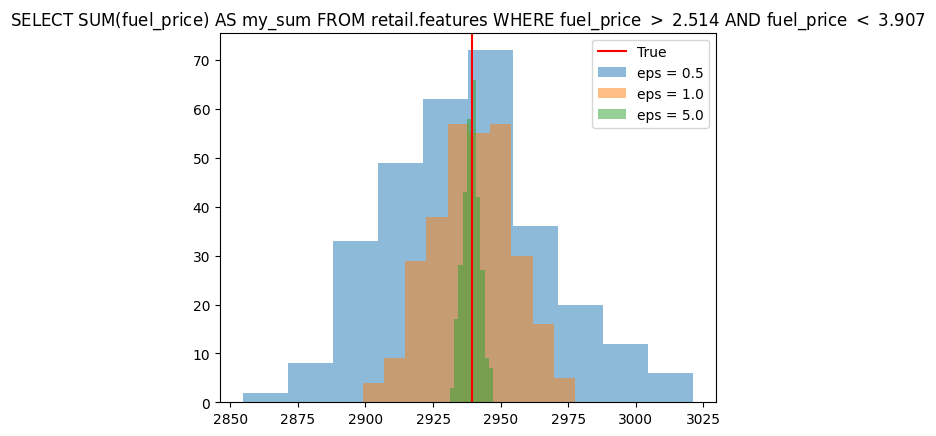

In [22]:
plot_hist(true_value, data, query)